In [1]:
from sklearn.decomposition import LatentDirichletAllocation,PCA
from sklearn.cluster import DBSCAN,AgglomerativeClustering,Birch
from sklearn.metrics import silhouette_score,pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import matplotlib.pyplot as plt
import porter
import string

0.7551272992249598
10


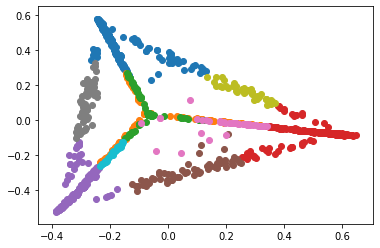

In [2]:
from sklearn.decomposition import LatentDirichletAllocation,PCA
from sklearn.cluster import DBSCAN,AgglomerativeClustering,Birch
from sklearn.metrics import silhouette_score,pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import matplotlib.pyplot as plt
import porter
import string

def getStopSet(path = "stopwords.txt"):#construct the stopwords to set to minimize the time
	with open(path) as file:
		newStopWords = []
		stopwords = file.readlines()
		for element in stopwords:
			newStopWords.append(element.strip())
		stopwords = set(newStopWords)
		return stopwords

def readContent(path = "cnnhealth.txt"):
	with open(path,encoding = 'utf-8') as file:
		content = []
		lines = file.readlines()
		for line in lines:
			line = line.split('|')
			content.append(line[2])
		return content

def preProcessing(content):
    stopSet = getStopSet()
    p = porter.PorterStemmer()
    info = []
    for line in content:
        newLine = ""
        line = line.split(" ")
        for element in line:
            temp = element.split("://")
            temp1 = element.split("@")
            temp2 = element.split("#")
            temp3 = element.split("/")
            if len(temp)<2 and len(temp1)<2 and len(temp2)<2 and len(temp3)<2:
                element = element.strip()#clean the '\n' 
                element = element.lower()
                element = element.translate(str.maketrans('','', string.punctuation))
                element = p.stem(element)
                if element not in stopSet:
                    newLine = newLine+element+" "
        output = ''.join(c for c in newLine if not c.isdigit())
        info.append(output)
    return info

def toVector(content,n_components):
	vectorizer = TfidfVectorizer()
	vector = vectorizer.fit_transform(content)
	vector = vector.toarray()
	lda = LatentDirichletAllocation(n_components=n_components)
	result = lda.fit_transform(vector)
	return result

def cluster(vector,eps,min_samples):
	#vector = pairwise_distances(vector,metric = 'manhattan')
	vector = pairwise_distances(vector,metric = 'euclidean')
	clustering = Birch(n_clusters=10).fit(vector)
	#clustering = DBSCAN(eps = eps,min_samples = min_samples,metric = 'manhattan').fit(vector)
	return clustering.labels_

def pca(vector):
	pca_vec =  PCA(n_components=2).fit_transform(vector)
	return pca_vec

def plot(vector,labels,numLabels):
	for i in range(numLabels):
		plt.scatter(vector[labels==i, 0], vector[labels==i, 1])
	plt.show()
	

content = readContent()
content = preProcessing(content)
vector = toVector(content,5)
result = cluster(vector,0.1,16)
print(silhouette_score(vector,result))
diffSet = set(result)
print(len(diffSet))
vector = pca(vector)
plot(vector,result,len(diffSet))


# heatmap

In [3]:
vector_euclid = pairwise_distances(vector,metric = 'euclidean')

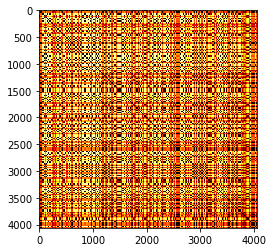

In [4]:
import matplotlib.pyplot as plt
import numpy as np


plt.imshow(vector_euclid, cmap='hot', interpolation='nearest')
plt.show()

# top features in cluster

In [5]:
import pandas as pd
def get_top_features_cluster(content, prediction, n_feats):
    labels = np.unique(prediction)
    vectorizer = TfidfVectorizer()
    vector = vectorizer.fit_transform(content)
    tf_idf_array = vector.toarray()

    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

In [6]:
def top_2_cluster(dfs):
    scores = []
    for i in dfs:
        score = i["score"].sum()
        scores.append(score)
    x = sorted(scores,reverse=True)[:2]
    best = scores.index(x[0])
    sec_best = scores.index(x[1])
    return best, sec_best

In [7]:
dfs = get_top_features_cluster(content,result, 20)
best, sec_best = top_2_cluster(dfs)

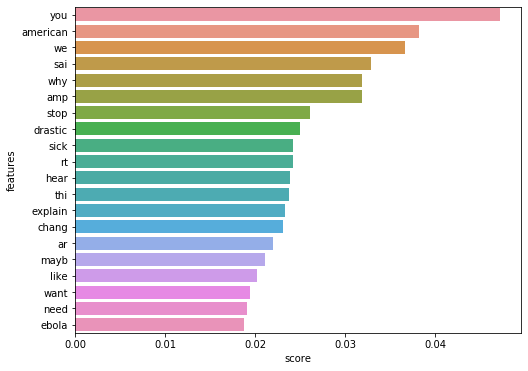

In [8]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[best][:20])

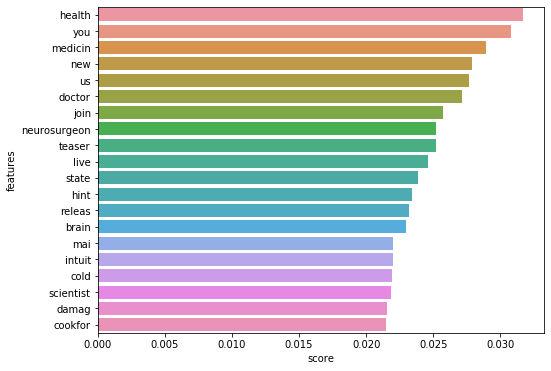

In [10]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[sec_best][:20])